# Optimisation pour le réseau CIGRE adapté

## First Network


In [2]:
# Uploading the network from CIGRE

import pandapower as pp
import pandapower.networks as pn


global net_cigre
global s
global Vn
global N

net_cigre = pn.create_cigre_network_mv(with_der="pv_wind") # Network with PV and wing DER

'''
This pandapower network includes the following parameter tables:
  - switch (8 elements)
  - load (18 elements)
  - ext_grid (1 elements)
  - sgen (9 elements)
  - line (15 elements)
  - trafo (2 elements)
  - bus (15 elements)
  - bus_geodata (15 elements)
'''

'\nThis pandapower network includes the following parameter tables:\n  - switch (8 elements)\n  - load (18 elements)\n  - ext_grid (1 elements)\n  - sgen (9 elements)\n  - line (15 elements)\n  - trafo (2 elements)\n  - bus (15 elements)\n  - bus_geodata (15 elements)\n'

# Desestabilisation du réseau

Objectif : Avoir des sur tensions au niveau des GED

Premier pas : Augmenter le puissance dans les noeuds 1 et 12 (les plus proches de la source)
Deuxième pas : Chager les puissances des generateurs pour desestabiliser le réseau pour avoir des surtensions

In [3]:
# Changer la puissance d'un générateur

net_cigre.sgen.at[8,'p_mw'] = 15
net_cigre.sgen.at[8,'sn_mva'] = 15

# On prend le générateur 8 parce qu'il possède le plus de puissance déjà et des producteurs éoliens
# fournissent des puissances en général plus élévées

pp.create_sgen(net_cigre,bus=1,p_mw=5,q_mvar=5,sn_mva=5,name='WKA 1',type='WP')
pp.create_sgen(net_cigre,bus=12,p_mw=5,q_mvar=5,sn_mva=5,name='WKA 12',type='WP')

pp.runpp(net_cigre) # run the network

## Optimisation mono-objective with genetic algorithm

Dans cette partie, il est developpé le problème d'optimisation avec un nombre fixé de selfs (s) afin de pouvoir vérifier si l'optimisation fonctionne à la main. Le problème est définit de la manière suivante :

##### Variables : 

$(q,x) \in \mathbb{R}^N \times \{0,1\}^N$

$q = (q_i)_{1 \leq i \leq N}$, $q_i$ [MVAr] : puissance reactive de la self au noeud i, active si $x_i = 1$

$x = (x_i)_{1 \leq i \leq N}$, $x_i$ [-] : variable binaire qui indique si le noeud i a un self installé

##### Paramètres :

N [-] : quantité de noeuds du réseau

s [-] : quantité de selfs à installer

$V_n$ [kV] : tension nominal du réseau (20 kV pour un réseau HTA)

##### Formulation du problème

La formulation du problème est similaire de la formulation pour la résolution avec l'algorithme deterministe SLSQP. Nous l'avons reformulé parce que l'utilisation d'un problème mixe dans ce cas permet que l'algorithme traite la constrainte d'égalité pour les selfs. Le problème d'optimisation est décrit ci-dessous :


$$
\begin{aligned}
\min_{q,x} \quad & \sum_{i=1}^{N}{q_{i}}  \quad & \textrm{s.t.} \quad & V_{i} \leq V_{max}\\
\quad & \quad & \quad & V_{i} \geq V_{min}    \\
\quad & \quad & \quad & q_{i} \geq 0,2    \\
\quad & \quad & \quad & \sum_{i=1}^{N}{x_{i}} = s    \\
\end{aligned}
$$


### 1) Cas avec s = 1


In [10]:
def fct_model_reseau(x):
    
    ##Variables du modèle :
    
    q_self = x[0:13] # q_selfi[MVAr]: puissance reactive installée comme self à chaque noeud i
    pos = x[14::]# pos[-]: position des selfs actives

    ##Paramètres du modèle :
    
    # s[-]: nb de selfs à installer
    # Vn[kV]: tension nominal du réseau
    N = len(q_self) #N[-]: nb de noeuds du réseau (exclut le noeud source)
    
    ##Éliminant des selfs inclus par la dernière itération de l'algo
    i=len(net_cigre.shunt)-1
    if len(net_cigre.shunt) > 0:
        while i>=0:
            net_cigre.shunt.drop(i, inplace=True)
            i-=1

    ##Creer des shunts
    for index in range(N):
        if pos[index] == 1:
            pp.create_shunt(net=net_cigre,bus = index+1,q_mvar = q_self[index],p_mw = 0) #On utilise index +1 pour éviter le noeud source (bus 0)

    ##Calcul avec pandapower des tension dans les noeuds
    pp.runpp(net_cigre)
    V_noeud_aux = (net_cigre.res_bus['vm_pu'].values.tolist())
    V_noeud = [Vn*i for i in V_noeud_aux[1::]] #On prend toutes les tensions au réseau sauf la tension au noeud source (bus 0)


    ##Calcul des outputs
    outputs = np.array(V_noeud) # 0.95Vn<V<1.05Vn : contrainte de tension avec limite supérieur et inférieur

    return outputs



In [41]:
net_cigre.shunt

Empty DataFrame
Columns: [bus, name, q_mvar, p_mw, vn_kv, step, max_step, in_service]
Index: []

 The best solution found:                                                                           
 [ 3.06073533  1.8115329   7.57636212  6.69929577  0.20687633 13.59187391
  2.26438085  8.66398529  2.65329581  2.69253593  8.11683508 15.71433708
  7.82352732 17.56056407  0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.        ]

 Objective function:
 2.264380846131025


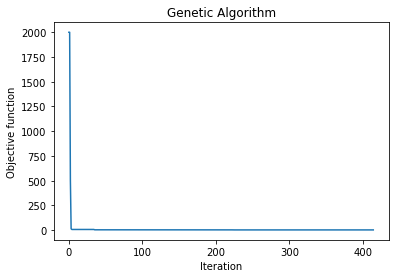

In [12]:
#Optimisations mono-objectif algo genetique
import numpy as np
import math
from geneticalgorithm import geneticalgorithm as ga

#Paramètres du modèle :

s = 1 # s[-]: nb de selfs à installer
Vn = 20 # Vn[kV]: tension nominal du réseau
N = 14 # N[-]: nb de noeuds du réseau

# Definisions les boundaries de la variables d'optimisation (qi peut être entre 0 et inf, si elle est active sa valeur minimale est 200 kVAr)
bounds =[]
for i in range(N):
    bounds.append([0,20])
for i in range(N):
    bounds.append([0,1])
bounds = np.array(bounds)

#Definisons des contraintes d'inégalité et égalité

lb_ineq_V =[]
ub_ineq_V =[]
lb_ineq_q =[]
ub_ineq_q =[]
lb_eq_s = s
ub_eq_s = s
for i in range(N):
    lb_ineq_V.append(0.95*Vn)
    ub_ineq_V.append(1.05*Vn)
for i in range(s):
    ub_ineq_q.append(math.inf)
    lb_ineq_q.append(0.2)

def nb_selfs(x):
    return sum(x[14::])

def q_installe(x):
    q_active_cons = []
    i=0
    for qi in x[0:14]:
        if x[14+i] == 1:
            q_active_cons.append(qi)
        i+=1
    return np.array(q_active_cons)

def f(x):
    try:
        pen=0
        #Première contrainte

        if nb_selfs(x)!= s:
            pen+=2000

        min_v = np.array(fct_model_reseau(x)).min()
        if min_v<np.array(lb_ineq_V)[1]:
            pen+=500*(np.array(lb_ineq_V)[1]-min_v)


        #Deuxième contrainte
        max_v = np.array(fct_model_reseau(x)).max()
        if max_v>np.array(ub_ineq_V)[1] :
            pen+=500*(max_v-np.array(ub_ineq_V)[1])
        
        #Troisième contrainte
        
        bad_q = q_installe(x).min()
        if bad_q<0.2:
            pen+=500*(0.2-bad_q)

        value = sum(q_installe(x))+pen
    except:
        value = 2000
    return value


#Solver

vartype=[]
for i in range(N):
    vartype.append(['real'])
for i in range(N):
    vartype.append(['int'])
vartype = np.array(vartype)

algorithm_param = {'max_num_iteration': 500,\
                   'population_size':100,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.7,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

model=ga(function=f,dimension=28,variable_type_mixed=vartype,variable_boundaries=bounds,algorithm_parameters=algorithm_param)

model.run()

In [14]:
fct_model_reseau(model.output_dict['variable'])

array([20.02446101, 20.08183749, 20.3439781 , 20.31131165, 20.2889476 ,
       20.26280546, 20.98627101, 20.55707233, 20.54008737, 20.51869543,
       20.5153168 , 20.53250986, 20.43866471, 20.38467529])

In [17]:
#Plotting the voltage with respect to the bus

import matplotlib.pyplot as plt
import numpy as np
    
# X axis parameter:
xaxis = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ,10, 11, 12, 13, 14])

# Y axis parameter:
yaxis = net_cigre.res_bus['vm_pu']

# Labels
plt.ylabel('V (p.u.)')
plt.xlabel('Noeud')

for i in range(len(yaxis)):
    plt.annotate(str(round(yaxis[i], 3)), xy=(xaxis[i], yaxis[i]+0.0008))

plt.grid()
plt.title('Tension à chaque noeud GA (s = 1)')
plt.plot(xaxis, yaxis, '-bo')
plt.show()

### 2) Cas avec s = 2

In [24]:
#Optimisations mono-objectif algo genetique
import numpy as np
import math
from geneticalgorithm import geneticalgorithm as ga

#Paramètres du modèle :

s = 2 # s[-]: nb de selfs à installer
Vn = 20 # Vn[kV]: tension nominal du réseau
N = 14 # N[-]: nb de noeuds du réseau

# Definisions les boundaries de la variables d'optimisation (qi peut être entre 0 et inf, si elle est active sa valeur minimale est 200 kVAr)
bounds =[]
for i in range(N):
    bounds.append([0,20])
for i in range(N):
    bounds.append([0,1])
bounds = np.array(bounds)

#Definisons des contraintes d'inégalité et égalité

lb_ineq_V =[]
ub_ineq_V =[]
lb_ineq_q =[]
ub_ineq_q =[]
lb_eq_s = s
ub_eq_s = s
for i in range(N):
    lb_ineq_V.append(0.95*Vn)
    ub_ineq_V.append(1.05*Vn)
for i in range(s):
    ub_ineq_q.append(math.inf)
    lb_ineq_q.append(0.2)

def nb_selfs(x):
    return sum(x[14::])

def q_installe(x):
    q_active_cons = []
    i=0
    for qi in x[0:N]:
        if x[N+i] == 1:
            q_active_cons.append(qi)
        i+=1
    return np.array(q_active_cons)

def f(x):
    try:
        pen=0
        #Première contrainte

        if nb_selfs(x)!= s:
            pen+=2000

        min_v = np.array(fct_model_reseau(x)).min()
        if min_v<np.array(lb_ineq_V)[1]:
            pen+=500*(np.array(lb_ineq_V)[1]-min_v)


        #Deuxième contrainte
        max_v = np.array(fct_model_reseau(x)).max()
        if max_v>np.array(ub_ineq_V)[1] :
            pen+=500*(max_v-np.array(ub_ineq_V)[1])
        
        #Troisième contrainte
        
        bad_q = q_installe(x).min()
        if bad_q<0.2:
            pen+=500*(0.2-bad_q)

        value = sum(q_installe(x))+pen
    except:
        value = 2000
    return value


#Solver

vartype=[]
for i in range(N):
    vartype.append(['real'])
for i in range(N):
    vartype.append(['int'])
vartype = np.array(vartype)

algorithm_param = {'max_num_iteration': 500,\
                   'population_size':100,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.7,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

model2=ga(function=f,dimension=28,variable_type_mixed=vartype,variable_boundaries=bounds,algorithm_parameters=algorithm_param)

model2.run()

 The best solution found:                                                                           
 [ 9.84661896  5.59997999  9.74979827 11.53267127 10.30512072  7.00421419
  0.83453411  1.69593981  5.76141344  5.61486394 16.15253002  4.53752399
  7.77076716 16.7457051   0.          0.          0.          0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.        ]

 Objective function:
 2.530473921517209


In [25]:
fct_model_reseau(model2.output_dict['variable'])
net_cigre.shunt

bus  name    q_mvar  p_mw  vn_kv  step  max_step  in_service
0    7  None  0.834534   0.0   20.0     1         1        True
1    8  None  1.695940   0.0   20.0     1         1        True

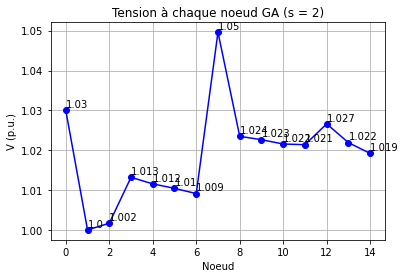

In [26]:
#Plotting the voltage with respect to the bus

import matplotlib.pyplot as plt
import numpy as np
    
# X axis parameter:
xaxis = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ,10, 11, 12, 13, 14])

# Y axis parameter:
yaxis = net_cigre.res_bus['vm_pu']

# Labels
plt.ylabel('V (p.u.)')
plt.xlabel('Noeud')

for i in range(len(yaxis)):
    plt.annotate(str(round(yaxis[i], 3)), xy=(xaxis[i], yaxis[i]+0.0008))

plt.grid()
plt.title('Tension à chaque noeud GA (s = 2)')
plt.plot(xaxis, yaxis, '-bo')
plt.show()

### 3) Cas avec s = 3

 The best solution found:                                                                           
 [ 2.88737165  0.58466239 16.43786479  5.15729041 16.12663327  9.45055095
  1.86285504  7.35642757  0.28659177  6.03746959  0.39093645 17.99671935
  3.48189463 11.32645451  0.          0.          0.          0.
  0.          0.          1.          0.          1.          0.
  1.          0.          0.          0.        ]

 Objective function:
 2.5403832666231563


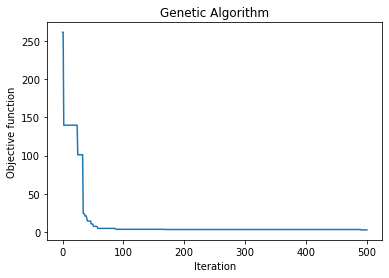

In [23]:
#Optimisations mono-objectif algo genetique
import numpy as np
import math
from geneticalgorithm import geneticalgorithm as ga

#Paramètres du modèle :

s = 3 # s[-]: nb de selfs à installer
Vn = 20 # Vn[kV]: tension nominal du réseau
N = 14 # N[-]: nb de noeuds du réseau

# Definisions les boundaries de la variables d'optimisation (qi peut être entre 0 et inf, si elle est active sa valeur minimale est 200 kVAr)
bounds =[]
for i in range(N):
    bounds.append([0,20])
for i in range(N):
    bounds.append([0,1])
bounds = np.array(bounds)

#Definisons des contraintes d'inégalité et égalité

lb_ineq_V =[]
ub_ineq_V =[]
lb_ineq_q =[]
ub_ineq_q =[]
lb_eq_s = s
ub_eq_s = s
for i in range(N):
    lb_ineq_V.append(0.95*Vn)
    ub_ineq_V.append(1.05*Vn)
for i in range(s):
    ub_ineq_q.append(math.inf)
    lb_ineq_q.append(0.2)

def nb_selfs(x):
    return sum(x[14::])

def q_installe(x):
    q_active_cons = []
    i=0
    for qi in x[0:N]:
        if x[N+i] == 1:
            q_active_cons.append(qi)
        i+=1
    return np.array(q_active_cons)

def f(x):
    try:
        pen=0
        #Première contrainte

        if nb_selfs(x)!= s:
            pen+=2000

        min_v = np.array(fct_model_reseau(x)).min()
        if min_v<np.array(lb_ineq_V)[1]:
            pen+=500*(np.array(lb_ineq_V)[1]-min_v)


        #Deuxième contrainte
        max_v = np.array(fct_model_reseau(x)).max()
        if max_v>np.array(ub_ineq_V)[1] :
            pen+=500*(max_v-np.array(ub_ineq_V)[1])
        
        #Troisième contrainte
        
        bad_q = q_installe(x).min()
        if bad_q<0.2:
            pen+=500*(0.2-bad_q)

        value = sum(q_installe(x))+pen
    except:
        value = 2000
    return value


#Solver

vartype=[]
for i in range(N):
    vartype.append(['real'])
for i in range(N):
    vartype.append(['int'])
vartype = np.array(vartype)

algorithm_param = {'max_num_iteration': 500,\
                   'population_size':100,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.7,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

model3=ga(function=f,dimension=28,variable_type_mixed=vartype,variable_boundaries=bounds,algorithm_parameters=algorithm_param)

model3.run()

In [27]:
fct_model_reseau(model3.output_dict['variable'])
net_cigre.shunt

bus  name    q_mvar  p_mw  vn_kv  step  max_step  in_service
0    7  None  1.862855   0.0   20.0     1         1        True
1    9  None  0.286592   0.0   20.0     1         1        True
2   11  None  0.390936   0.0   20.0     1         1        True

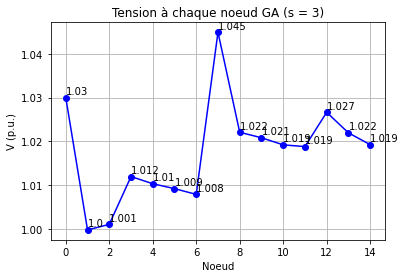

In [28]:
#Plotting the voltage with respect to the bus

import matplotlib.pyplot as plt
import numpy as np
    
# X axis parameter:
xaxis = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ,10, 11, 12, 13, 14])

# Y axis parameter:
yaxis = net_cigre.res_bus['vm_pu']

# Labels
plt.ylabel('V (p.u.)')
plt.xlabel('Noeud')

for i in range(len(yaxis)):
    plt.annotate(str(round(yaxis[i], 3)), xy=(xaxis[i], yaxis[i]+0.0008))

plt.grid()
plt.title('Tension à chaque noeud GA (s = 3)')
plt.plot(xaxis, yaxis, '-bo')
plt.show()

### 4) Cas avec s = 4

 The best solution found:                                                                           
 [12.0447861  15.45987008  9.26441574  9.14054993  1.01876388  9.68929945
  0.71623045  8.49288684  0.20448431 13.41876472  0.78602005 18.40838323
 17.53389605 12.29125211  0.          0.          0.          0.
  1.          0.          1.          0.          1.          0.
  1.          0.          0.          0.        ]

 Objective function:
 2.725498698858604


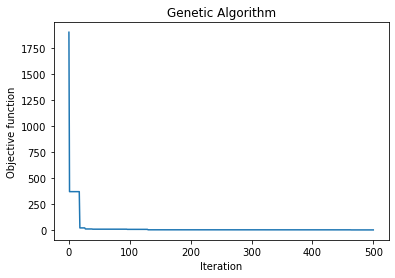

In [29]:
#Optimisations mono-objectif algo genetique
import numpy as np
import math
from geneticalgorithm import geneticalgorithm as ga

#Paramètres du modèle :

s = 4 # s[-]: nb de selfs à installer
Vn = 20 # Vn[kV]: tension nominal du réseau
N = 14 # N[-]: nb de noeuds du réseau

# Definisions les boundaries de la variables d'optimisation (qi peut être entre 0 et inf, si elle est active sa valeur minimale est 200 kVAr)
bounds =[]
for i in range(N):
    bounds.append([0,20])
for i in range(N):
    bounds.append([0,1])
bounds = np.array(bounds)

#Definisons des contraintes d'inégalité et égalité

lb_ineq_V =[]
ub_ineq_V =[]
lb_ineq_q =[]
ub_ineq_q =[]
lb_eq_s = s
ub_eq_s = s
for i in range(N):
    lb_ineq_V.append(0.95*Vn)
    ub_ineq_V.append(1.05*Vn)
for i in range(s):
    ub_ineq_q.append(math.inf)
    lb_ineq_q.append(0.2)

def nb_selfs(x):
    return sum(x[14::])

def q_installe(x):
    q_active_cons = []
    i=0
    for qi in x[0:N]:
        if x[N+i] == 1:
            q_active_cons.append(qi)
        i+=1
    return np.array(q_active_cons)

def f(x):
    try:
        pen=0
        #Première contrainte

        if nb_selfs(x)!= s:
            pen+=2000

        min_v = np.array(fct_model_reseau(x)).min()
        if min_v<np.array(lb_ineq_V)[1]:
            pen+=500*(np.array(lb_ineq_V)[1]-min_v)


        #Deuxième contrainte
        max_v = np.array(fct_model_reseau(x)).max()
        if max_v>np.array(ub_ineq_V)[1] :
            pen+=500*(max_v-np.array(ub_ineq_V)[1])
        
        #Troisième contrainte
        
        bad_q = q_installe(x).min()
        if bad_q<0.2:
            pen+=500*(0.2-bad_q)

        value = sum(q_installe(x))+pen
    except:
        value = 2000
    return value


#Solver

vartype=[]
for i in range(N):
    vartype.append(['real'])
for i in range(N):
    vartype.append(['int'])
vartype = np.array(vartype)

algorithm_param = {'max_num_iteration': 500,\
                   'population_size':100,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.7,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

model4=ga(function=f,dimension=28,variable_type_mixed=vartype,variable_boundaries=bounds,algorithm_parameters=algorithm_param)

model4.run()

In [30]:
fct_model_reseau(model4.output_dict['variable'])
net_cigre.shunt

bus  name    q_mvar  p_mw  vn_kv  step  max_step  in_service
0    5  None  1.018764   0.0   20.0     1         1        True
1    7  None  0.716230   0.0   20.0     1         1        True
2    9  None  0.204484   0.0   20.0     1         1        True
3   11  None  0.786020   0.0   20.0     1         1        True

In [31]:
#Plotting the voltage with respect to the bus

import matplotlib.pyplot as plt
import numpy as np
    
# X axis parameter:
xaxis = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ,10, 11, 12, 13, 14])

# Y axis parameter:
yaxis = net_cigre.res_bus['vm_pu']

# Labels
plt.ylabel('V (p.u.)')
plt.xlabel('Noeud')

for i in range(len(yaxis)):
    plt.annotate(str(round(yaxis[i], 3)), xy=(xaxis[i], yaxis[i]+0.0008))

plt.grid()
plt.title('Tension à chaque noeud GA (s = 4)')
plt.plot(xaxis, yaxis, '-bo')
plt.show()